In [1]:
# === Imports === #

# My imports
import os
import subprocess
import pandas as pd
from tqdm import tqdm
import shutil

# Various python packages are used in this notebook. Please get yourself used to them (optional).
import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.preprocessing   import LabelBinarizer    # used for splitting the gender column
from sklearn.preprocessing   import MinMaxScaler      # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe
import cv2                                            # OpenCV used for image processing
import random   #random number generator
import datetime #used to get current date/time
import math     #math/numerical functions
import os       #os specific functions, like file open/close etc.
import gc       #garbage collection module -- used to manually clean up memory spaces/references.


from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network
from keras.models import Sequential #keras model architectures
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten,Dropout, BatchNormalization #types of layers
from keras.losses import mean_squared_error, huber, log_cosh  #built-in loss 
from tensorflow.python.keras.saving import hdf5_format  #used for saving models 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard  #callbacks
from keras.models import model_from_json  #used for loading model architecture from json file
import h5py  #saved model type

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0: #If you have at least one "configured" GPU, let's use it; otherwise, pass
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import pickle 

# data augmentation
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import requests

import warnings

In [2]:
"""
Setting work environment with dataset. If on Google colaboratory, we need to extract dataset stored in google drive,
otherwise the dataset is already there.
"""
try:
    from google.colab import drive
    print('Running on Google colab...')
    drive.mount('/content/drive')
    #import zipfile
    #with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/csci5931sp22/PA2-dataset/Archive.zip', 'r') as zip_ref:
    #    zip_ref.extractall('dataset/')
except:
    print('Running on local machine...')

Running on Google colab...
Mounted at /content/drive


In [3]:
folder_path = './drive/MyDrive/Colab Notebooks/DAiSEE/'

all_labels = pd.read_csv(os.path.join(folder_path, 'Labels/AllLabels.csv'))

# Find the labels for a single sample
file_extension = '.avi'
sample_num = '5000441001' + file_extension
all_labels[all_labels['ClipID']==sample_num].values.tolist()[0][-4:]

[1, 2, 0, 0]

In [4]:
def data_aug(input_data):
    input_data = np.array(input_data)
    assert len(input_data.shape) == 4
    generator = ImageDataGenerator(fill_mode='nearest', dtype=int)
    generator.width_shift_range = 0.1
    generator.height_shift_range = 0.1
    generator.zoom_range = [0.80, 1.2]
    generator.rotation_range = 2
    generator.horizontal_flip = True
    generator.vertical_flip = False
    generator.fit(input_data)
    flow = generator.flow(input_data)
    return flow


desired_img_shape = (299,224)

'''
Returns a variable-length list of images.
'''
def load_video(path, target_frames=10, resize=desired_img_shape):
    
    cap = cv2.VideoCapture(path)
    frames = []
    try:

        frame_skip = cap.get(cv2.CAP_PROP_FRAME_COUNT) // target_frames
        frame_skip = int(frame_skip)

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]] # BGR -> RGB

            frames.append(frame.astype('uint8'))

            if len(frames) == target_frames:
                break
            else:
                for _ in range(frame_skip-1):
                    ret, frame = cap.read()
    finally:
        cap.release()

    # Check if we need to do augmentation to reach target
    if not len(frames) == target_frames:
        augmentation = data_aug(frames[:]) # copy over the existing slides to set up the generator
        while len(frames) < target_frames:
            frames.append(next(augmentation)[0].astype('uint8'))

    try:
        assert len(frames) == target_frames
    except AssertionError:
        warnings.warn('\n Frames generated: %d; Frames requested: %d \n' %(len(frames), target_frames))

    return np.array(frames)

In [5]:
sample_path = os.path.join(folder_path, 'DataSet', 'Train', '110001', '1100011002', '1100011002.avi')
print(sample_path)

./drive/MyDrive/Colab Notebooks/DAiSEE/DataSet/Train/110001/1100011002/1100011002.avi


In [6]:
samples = load_video(sample_path, target_frames=500)

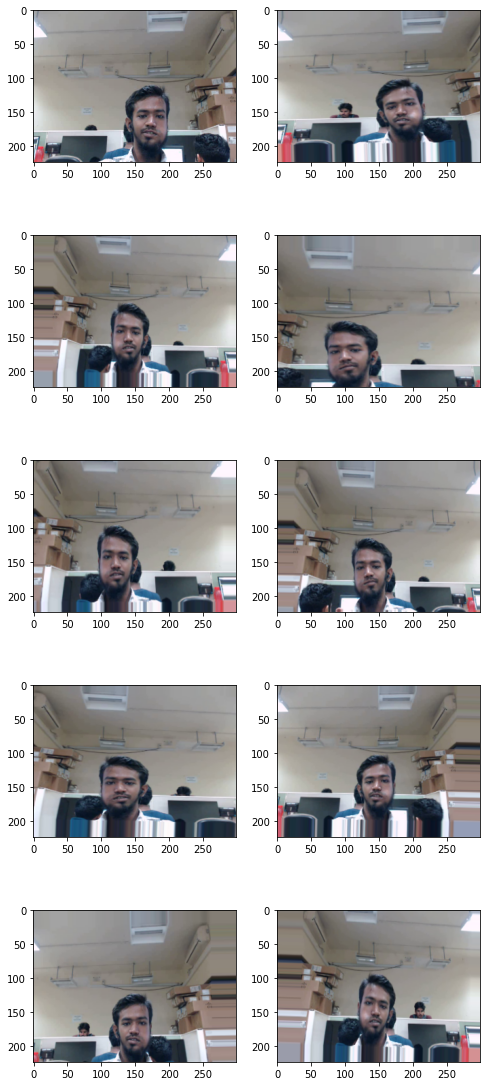

In [7]:
desired_img_shape = (299,224)
w = 299
h = 224
fig = plt.figure(figsize=(8, 20))
columns = 2
rows = 5
for i in range(0, columns*rows):
    img = samples[-i].astype('uint8')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

In [8]:
# Locate the gender labels
labels = pd.read_csv(os.path.join(folder_path, 'Labels', 'AllLabels.csv'))
females = pd.read_csv(os.path.join(folder_path, 'GenderClips', 'Females'), header=None)
males = pd.read_csv(os.path.join(folder_path, 'GenderClips', 'Males'), header=None)

labels = labels.astype({'Engagement': int})

females_list = [x[0] for x in females.values.tolist()]
males_list = [x[0] for x in males.values.tolist()]

# generate the reference lists for gender
engagement_levels = [0,1,2,3]

engagement_level_lists = []

for engagement_level in engagement_levels:

    label_filtered = labels[labels['Engagement'] == engagement_level]
    label_filtered_list = label_filtered.values.tolist()

    females = []
    for item in label_filtered_list:
        if item[0] == '1110031003.avi':
            print('F')
        if item[0] in females_list:
            females.append(item)

            

    males = []
    for item in label_filtered_list:
        if item[0] == '1110031003.avi':
            print('M')
        if item[0] in males_list:
            males.append(item)

            
            
    engagement_level_lists.append((males, females))


F
M


In [9]:
hist_data = []    

for index, engagement_level_list in enumerate(engagement_level_lists):

    print("For engagement level " + str(engagement_levels[index]) + " there are: ")
    
    m = len(engagement_level_list[0])
    
    print(str(len(engagement_level_list[0])) + " male samples. A random sample is:")
    random_sample_index = np.random.randint(0, len(engagement_level_list[0]))
    print(engagement_level_list[0][random_sample_index])
    
    f = len(engagement_level_list[1])
    
    print(str(len(engagement_level_list[1])) + " female samples A random sample is:")
    random_sample_index = np.random.randint(0, len(engagement_level_list[1]))
    print(engagement_level_list[1][random_sample_index])
    
    print('')
            
    hist_data.append([m,f])

For engagement level 0 there are: 
45 male samples. A random sample is:
['3100821052.avi', 0, 0, 0, 0]
16 female samples A random sample is:
['4110211040.avi', 2, 0, 1, 0]

For engagement level 1 there are: 
307 male samples. A random sample is:
['4100251032.avi', 2, 1, 0, 0]
148 female samples A random sample is:
['3344630121.avi', 2, 1, 1, 1]

For engagement level 2 there are: 
3460 male samples. A random sample is:
['5100092053.avi', 1, 2, 0, 0]
962 female samples A random sample is:
['522129018.avi', 1, 2, 2, 0]

For engagement level 3 there are: 
2416 male samples. A random sample is:
['5100381048.avi', 2, 3, 0, 0]
1571 female samples A random sample is:
['2026140272.mp4', 0, 3, 1, 0]



In [12]:
subset_directory = os.path.join(folder_path, 'DataSet')
subsets = ['Train', 'Test', 'Validation']

generated_folder = 'gen-unskew-1' # This will be the destination folder name
generated_extension = '.png'
resize_scale = "299:224"

SIMPLE_FLAG = False # Set to true to generate only a single video from each person
BASELINE_FRAME_QTY = 10

# remove existing folder for replacement
if generated_folder in os.listdir(folder_path):
    shutil.rmtree(os.path.join(folder_path, generated_folder))
os.makedirs(os.path.join(folder_path, generated_folder))
target_directory = os.path.join(folder_path, generated_folder)

for subset in subsets:
    subset_path = os.path.join(subset_directory, subset)

    os.makedirs(os.path.join(folder_path, generated_folder, subset))

    persons = os.listdir(subset_path)
    for person in tqdm(persons):
        person_path = os.path.join(subset_path, person)
        person_videos = os.listdir(person_path)
        for person_video in person_videos:
            try:

                person_video_path = os.path.join(person_path, person_video)
                
                if len(os.listdir(person_video_path)) == 0:
                    continue

                filename = os.listdir(person_video_path)[0]
                source_path = os.path.join(person_video_path, filename)

                file_ID = filename[:-4]

                # Manually calculated ratios to generate samples in the specific class
                ratio_table = [[76, 216],
                               [11, 23],
                               [1, 3],
                               [1, 2]]

                target_frame_qty = -1
                # Now we need to determine how many of the specific category to generate from this sample
                for engagement_level_index, engagement_level in enumerate(engagement_level_lists):
                    for gender_index, gender in enumerate(engagement_level):
                        if filename in [dataline[0] for dataline in gender]:
                            target_frame_qty = BASELINE_FRAME_QTY * ratio_table[engagement_level_index][gender_index]
                
                # warn if label isn't found
                if target_frame_qty == -1:
                    warnings.warn("\n Label not found for sample %s \n" % filename)
                    target_frame_qty = BASELINE_FRAME_QTY

                samples = load_video(source_path, target_frames=target_frame_qty)

                for sample_index, sample in enumerate(samples):
                    target_path = os.path.join(target_directory, subset, file_ID + '-' + str(sample_index) + generated_extension)
                    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
                    cv2.imwrite(target_path, sample)

            except Exception as e:
                print("error with " + person_video)
                #print(str(e))
                import traceback
                traceback.print_exc()

            if SIMPLE_FLAG: break


 86%|████████▌ | 18/21 [52:32<19:01, 380.46s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: 
 Label not found for sample 9877360170.avi 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: 
 Label not found for sample 9877360172.avi 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: 
 Label not found for sample 987736017.avi 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: 
 Label not found for sample 9877360173.avi 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: 
 Label not found for sample 9877360177.avi 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: 
 Label not found for sample 9877360181.avi 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: 
 Label not found for sample 9877360183.avi 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: 
 Label

In [ ]:
print("Success...")

Success...


https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3